In [147]:
import numpy as np
import pandas as pd
from sklearn.semi_supervised import LabelPropagation
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import glob

# Data Import

In [60]:
pict_dir = "../data/pict_push-ups-from-side/2-1.COCO-pose/"
movi_dir = "../data/movie_push-ups-from-side/2-1.COCO-pose/"

print(glob.glob(pict_dir + "*"))
print(glob.glob(movi_dir + "*"))

['../data/pict_push-ups-from-side/2-1.COCO-pose/0_up.csv', '../data/pict_push-ups-from-side/2-1.COCO-pose/1_down.csv', '../data/pict_push-ups-from-side/2-1.COCO-pose/Z_estimate-error.csv']
['../data/movie_push-ups-from-side/2-1.COCO-pose/IMG_7471.csv', '../data/movie_push-ups-from-side/2-1.COCO-pose/IMG_7470.csv', '../data/movie_push-ups-from-side/2-1.COCO-pose/VID_20171128_174622.csv', '../data/movie_push-ups-from-side/2-1.COCO-pose/VID_20171128_174702.csv', '../data/movie_push-ups-from-side/2-1.COCO-pose/IMG_4936.csv', '../data/movie_push-ups-from-side/2-1.COCO-pose/IMG_4937.csv']


## データの選定
幡山さんの写ってる動画がよく関節位置が取れていて良さそうだからこれに絞る

In [118]:
pict_up_file = ["IMG_{}.JPG".format(i) for i in range(4924, 4930)] # + 
               # ["IMG_{}.JPG".format(i) for i in range(4924, 4930)] # 後半は関節認識がうまくいってない
pict_down_file = ["IMG_{}.JPG".format(i) for i in range(4930, 4936)] # + 
               # ["IMG_{}.JPG".format(i) for i in range(4924, 4930)] # 後半は関節認識がうまくいってない
movi_base = "IMG_4937"
movi_file = movi_base + ".csv"

Load

In [62]:
data = np.loadtxt(pict_dir + "0_up.csv", delimiter=",", dtype=str)

m, n = data.shape
for i in range(m):
    for j in range(n):
        data[i, j] = data[i, j][2:-1]
        
up_data = data[:, :-1].astype(float)
img_name = data[:, -1]

filter_img = [img in pict_up_file for img in img_name]
up_data = up_data[filter_img, :]

In [63]:
data = np.loadtxt(pict_dir + "1_down.csv", delimiter=",", dtype=str)

m, n = data.shape
for i in range(m):
    for j in range(n):
        data[i, j] = data[i, j][2:-1]
        
down_data = data[:, :-1].astype(float)
img_name = data[:, -1]

filter_img = [img in pict_down_file for img in img_name]
down_data = down_data[filter_img, :]

In [64]:
movie_data = np.loadtxt(movi_dir + movi_file, delimiter=",", usecols=range(54))

## 特徴量設計
左右の肩・肘・手の間の距離を使う

|関節名|番号|
|:------|:------|
| 右肩 | 2 |
| 右肘 | 3 |
| 右手 | 4 |
| 左肩 | 5 |
| 左肘 | 6 |
| 左手 | 7 |

~~左右どちらを使うかは、関節はConfidenceの和で決める~~
右に固定

In [92]:
def chooseRL(data):
    '''
    data: data_num x 54
    '''
    right = np.arange(2, 5)
    left = np.arange(5, 8)
    conf_r = np.mean(data[:, right*3 + 2], axis=1)
    conf_l = np.mean(data[:, left*3 + 2], axis=1)
    conf = np.vstack([conf_r, conf_l])
    argmax_conf = np.argmax(conf, axis=0)
    max_conf = np.max(conf, axis=0)
    
    pos_r = np.dstack([data[:, right*3], data[:, right*3+1]]).reshape(-1, 6)
    pos_l = np.dstack([data[:, left*3], data[:, left*3+1]]).reshape(-1, 6)
    pos = np.hstack([pos_r, pos_l])
    print(argmax_conf)
    out = pos[argmax_conf*6:argmax_conf*6+6]
    return out

def extractJointPos(data, index_list):
    return np.dstack([data[:, index_list*3], data[:, index_list*3+1]]).reshape(-1, 2*len(index_list))

def extractJointConf(data, index_list):
    return data[:, index_list*3+2]

In [93]:
right = np.arange(2, 5)
up_pos, up_conf = extractJointPos(up_data, right), extractJointConf(up_data, right)
down_pos, down_conf = extractJointPos(down_data, right), extractJointConf(down_data, right)
movie_pos, movie_conf = extractJointPos(movie_data, right), extractJointConf(movie_data, right)

In [101]:
# 位置の正規化
nm_up_pos = up_pos / np.max(up_data, axis=1)[:, np.newaxis]
nm_down_pos = down_pos / np.max(down_data, axis=1)[:, np.newaxis]
nm_movie_pos = movie_pos / np.max(movie_data, axis=1)[:, np.newaxis]

In [ ]:
# とりあえず特徴量は作らず、生で学習する

# confidenceに付いて分析

<IPython.core.display.Javascript object>


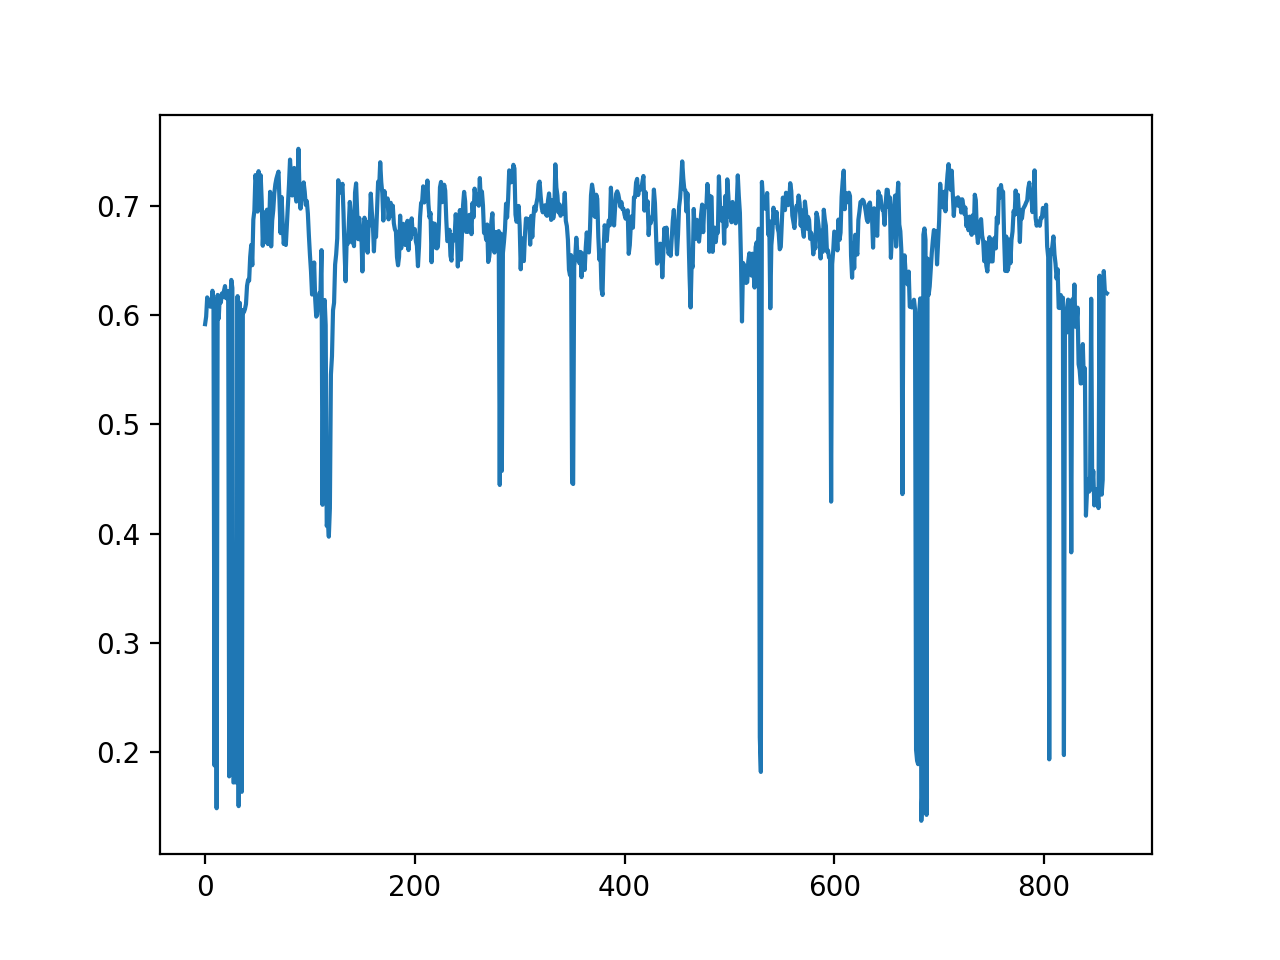

In [164]:
plt.plot(np.mean(movie_conf, axis=1))
plt.show()

<IPython.core.display.Javascript object>


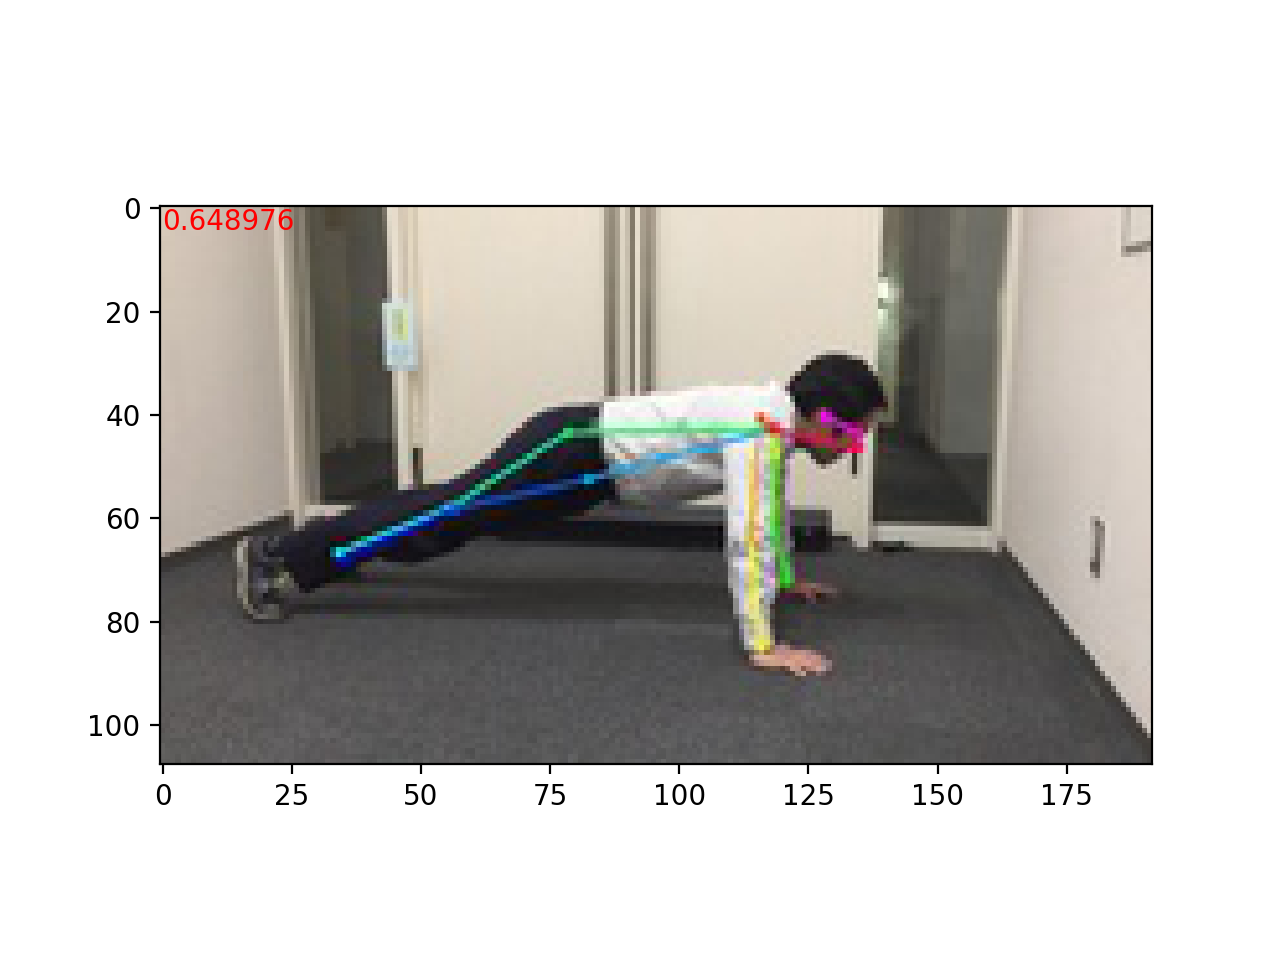

In [160]:
%matplotlib nbagg

fig = plt.figure()
imgs_pardir = "../data/movie_push-ups-from-side/2-3.COCO-pict-mini/"
imgs_folder = imgs_pardir + movi_base

img_files = sorted(glob.glob(imgs_folder + "/*.jpg"))
test_img_files = img_files

ims = []
for i, img_file in enumerate(test_img_files):
    img = plt.imread(img_file)
    text = "%.3f" % np.mean(movie_conf, axis=1)[i]
    ims.append([plt.imshow(img), plt.text(0, 0, text, ha="left", va="top", color="red")])
    
ani = animation.ArtistAnimation(fig, ims, interval=10, repeat=True)
plt.show()

# 半教師あり学習
結果：やっぱり、クラス間がきっぱり分かれずに連続的に変化してないから微妙な気がする

くっつけてラベルも作る

| クラス | ラベル |
|:------|------:|
|up|1|
|down|0|
|unknown|-1|

In [110]:
test_ratio = 0.5
train_max_index = int(nm_movie_pos.shape[0]*(1 - test_ratio))
train_nm_movie_pos = nm_movie_pos[:train_max_index, :]
test_nm_movie_pos = nm_movie_pos[train_max_index:, :]

train_data = np.vstack([nm_up_pos, nm_down_pos, train_nm_movie_pos])
test_data = test_nm_movie_pos
print(train_data.shape)

(442, 6)

In [109]:
labels = np.hstack([
    1 * np.ones(nm_up_pos.shape[0], dtype=int),
    0 * np.ones(nm_down_pos.shape[0], dtype=int),
    -1* np.ones(train_nm_movie_pos.shape[0], dtype=int)
])
print(labels.shape)

(442,)

In [111]:
clf = LabelPropagation()
clf.fit(train_data, labels)

LabelPropagation(alpha=None, gamma=20, kernel='rbf', max_iter=1000, n_jobs=1,
         n_neighbors=7, tol=0.001)

In [112]:
pred_label = clf.predict(test_data)

In [114]:
pred_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0,

<IPython.core.display.Javascript object>


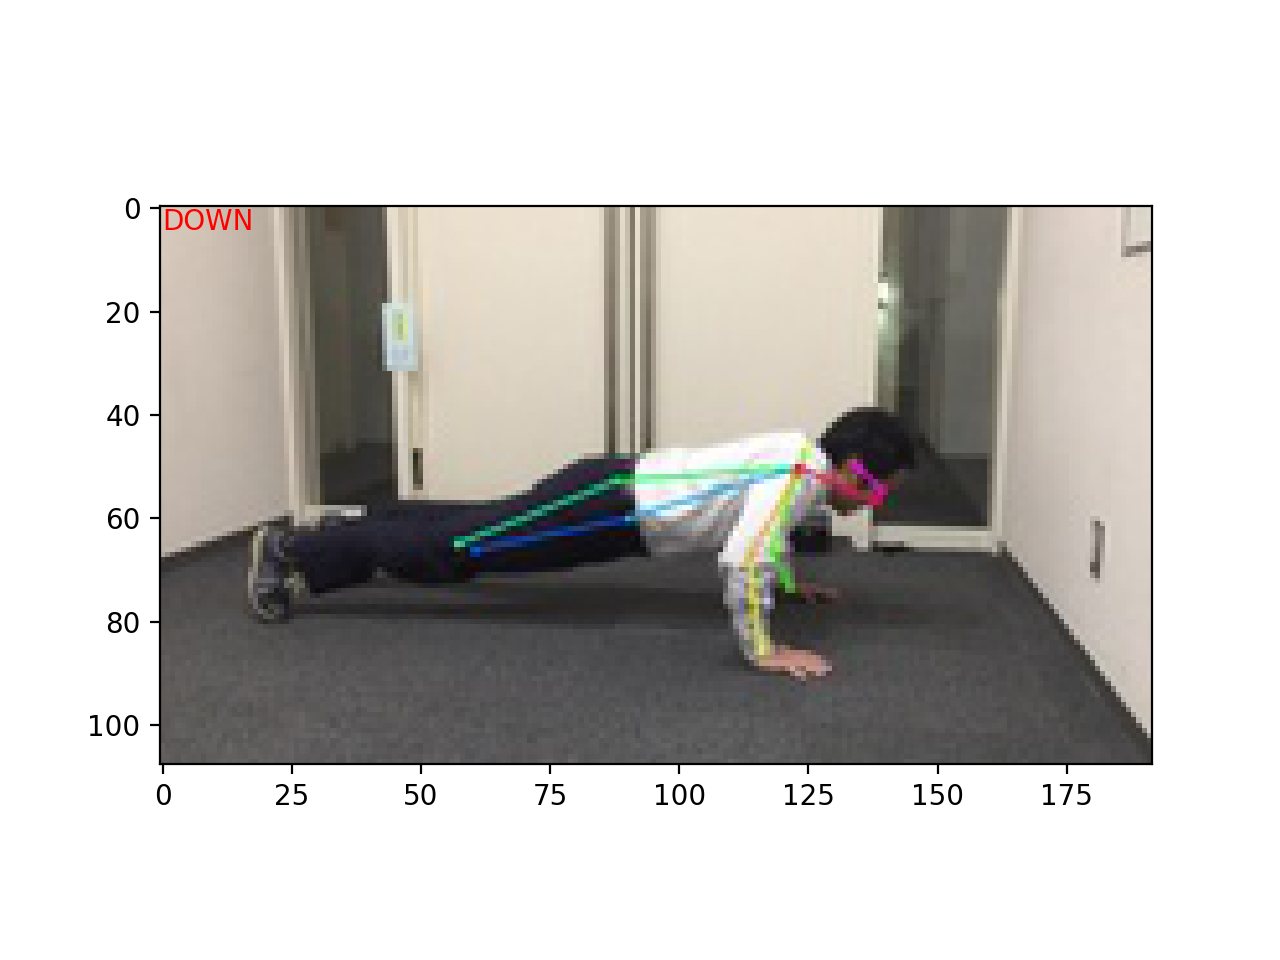

In [138]:
%matplotlib nbagg

fig = plt.figure()
imgs_pardir = "../data/movie_push-ups-from-side/2-3.COCO-pict-mini/"
imgs_folder = imgs_pardir + movi_base

img_files = sorted(glob.glob(imgs_folder + "/*.jpg"))
test_img_files = img_files[train_max_index:]

ims = []
for i, img_file in enumerate(test_img_files):
    img = plt.imread(img_file)
    text = "UP" if pred_label[i] == 1 else "DOWN"
    ims.append([plt.imshow(img), plt.text(0, 0, text, ha="left", va="top", color="red")])
    
ani = animation.ArtistAnimation(fig, ims, interval=10, repeat=True)
plt.show()

# 半教師あり学習（低Confは無視）
結果：やっぱり、クラス間がきっぱり分かれずに連続的に変化してないから微妙な気がする

くっつけてラベルも作る

| クラス | ラベル |
|:------|------:|
|up|1|
|down|0|
|unknown|-1|

In [179]:
conf_thresh = .7

In [180]:
test_ratio = 0.5
train_max_index = int(nm_movie_pos.shape[0]*(1 - test_ratio))
train_nm_movie_pos = nm_movie_pos[:train_max_index, :]
train_nm_movie_pos = train_nm_movie_pos[np.mean(movie_conf, axis=1)[:train_max_index] > conf_thresh]
test_nm_movie_pos = nm_movie_pos[train_max_index:, :]

train_data = np.vstack([nm_up_pos, nm_down_pos, train_nm_movie_pos])
test_data = test_nm_movie_pos
print(train_data.shape)

(136, 6)


In [181]:
labels = np.hstack([
    1 * np.ones(nm_up_pos.shape[0], dtype=int),
    0 * np.ones(nm_down_pos.shape[0], dtype=int),
    -1* np.ones(train_nm_movie_pos.shape[0], dtype=int)
])
print(labels.shape)

(136,)


In [182]:
clf = LabelPropagation()
clf.fit(train_data, labels)

LabelPropagation(alpha=None, gamma=20, kernel='rbf', max_iter=1000, n_jobs=1,
         n_neighbors=7, tol=0.001)

In [183]:
pred_label = clf.predict(test_data)
print(pred_label)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [184]:
pred_label[np.mean(movie_conf, axis=1)[train_max_index:] < conf_thresh] = -1
print(pred_label)

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  0
  0  0  0  0 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1  0
  0 -1  0  0 -1 -1 -1 -1 -1 -1  0  0 -1 -1 -1 -1  0 -1  0  0 -1 -1 -1  0 -1
  0 -1  0  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1  0  0 -1 -1  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1  0
  0  0  0  0  0 -1 -1 -1 -1 -1 -1  0  0 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1  0  0  0 -1  0  0  0  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  0  0  0  0
 -1 -1 -1  0  0 -1 -1 -1 -1 -1 -1 -1  0  0  0  0 -1 -1 -1  0  0  0 -1  0 -1
 -1 -1 -1  0 -1  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  0  0 -1
  0 -1  0  0  0  0  0  0  0 -1  0  0  0  0 -1  0 -1  0  0 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1  0  0

<IPython.core.display.Javascript object>


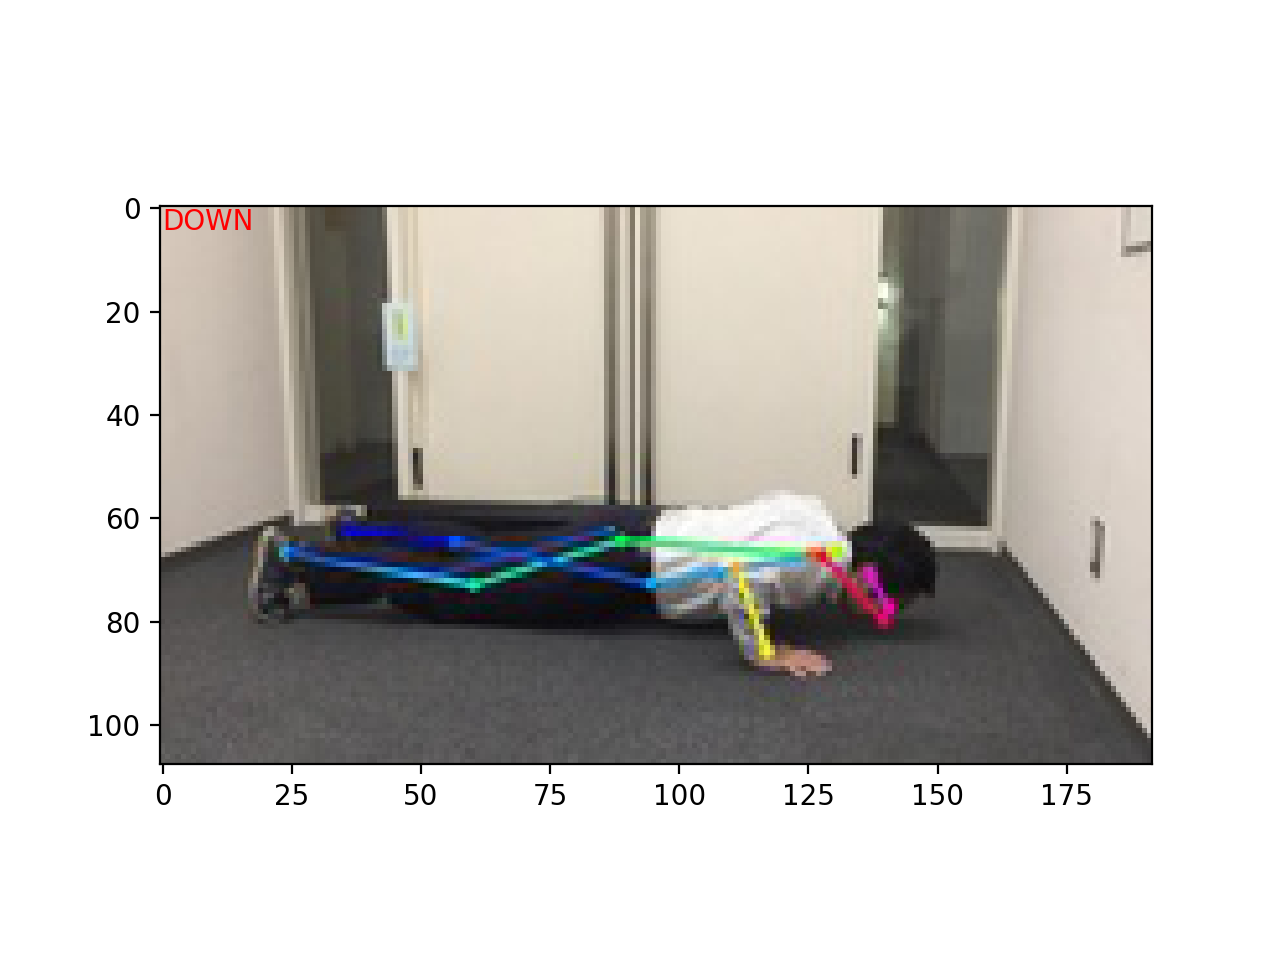

In [185]:
%matplotlib nbagg

fig = plt.figure()
imgs_pardir = "../data/movie_push-ups-from-side/2-3.COCO-pict-mini/"
imgs_folder = imgs_pardir + movi_base

img_files = sorted(glob.glob(imgs_folder + "/*.jpg"))
test_img_files = img_files[train_max_index:]

ims = []
for i, img_file in enumerate(test_img_files):
    img = plt.imread(img_file)
    if pred_label[i] == 1:
        text = "UP"
    elif pred_label[i] == 0:
        text = "DOWN"
    else:
        text = "UNKNOWN"
    ims.append([plt.imshow(img), plt.text(0, 0, text, ha="left", va="top", color="red")])
    
ani = animation.ArtistAnimation(fig, ims, interval=10, repeat=True)
plt.show()

## SVM
ラベルつきの画像は全てtrainにする

In [139]:
train_data = np.vstack([nm_up_pos, nm_down_pos])
test_data = nm_movie_pos

In [140]:
labels = np.hstack([
    1 * np.ones(nm_up_pos.shape[0], dtype=int),
    0 * np.ones(nm_down_pos.shape[0], dtype=int)
])
print(labels.shape)

(12,)


In [142]:
clf = SVC()
clf.fit(train_data, labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [143]:
pred_label = clf.predict(test_data)

In [144]:
pred_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0,

<IPython.core.display.Javascript object>


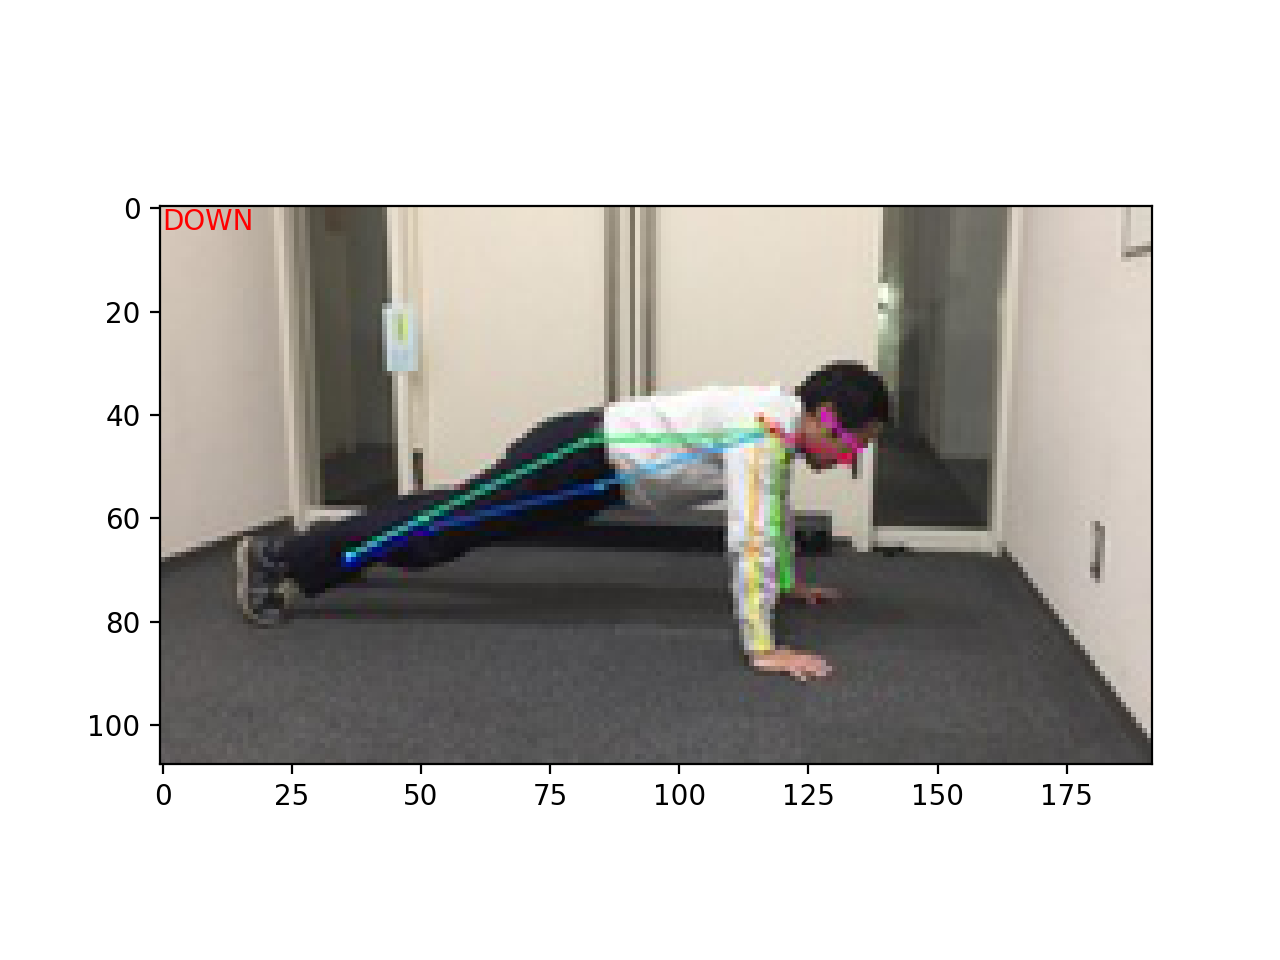

In [146]:
%matplotlib nbagg

fig = plt.figure()
imgs_pardir = "../data/movie_push-ups-from-side/2-3.COCO-pict-mini/"
imgs_folder = imgs_pardir + movi_base

img_files = sorted(glob.glob(imgs_folder + "/*.jpg"))
test_img_files = img_files

ims = []
for i, img_file in enumerate(test_img_files):
    img = plt.imread(img_file)
    text = "UP" if pred_label[i] == 1 else "DOWN"
    ims.append([plt.imshow(img), plt.text(0, 0, text, ha="left", va="top", color="red")])
    
ani = animation.ArtistAnimation(fig, ims, interval=10, repeat=True)
plt.show()

# Random Forest
ラベルつきの画像は全てtrainにする

In [148]:
train_data = np.vstack([nm_up_pos, nm_down_pos])
test_data = nm_movie_pos

In [149]:
labels = np.hstack([
    1 * np.ones(nm_up_pos.shape[0], dtype=int),
    0 * np.ones(nm_down_pos.shape[0], dtype=int)
])
print(labels.shape)

(12,)


In [150]:
clf = RandomForestClassifier()
clf.fit(train_data, labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [151]:
pred_label = clf.predict(test_data)

In [152]:
pred_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0,

<IPython.core.display.Javascript object>


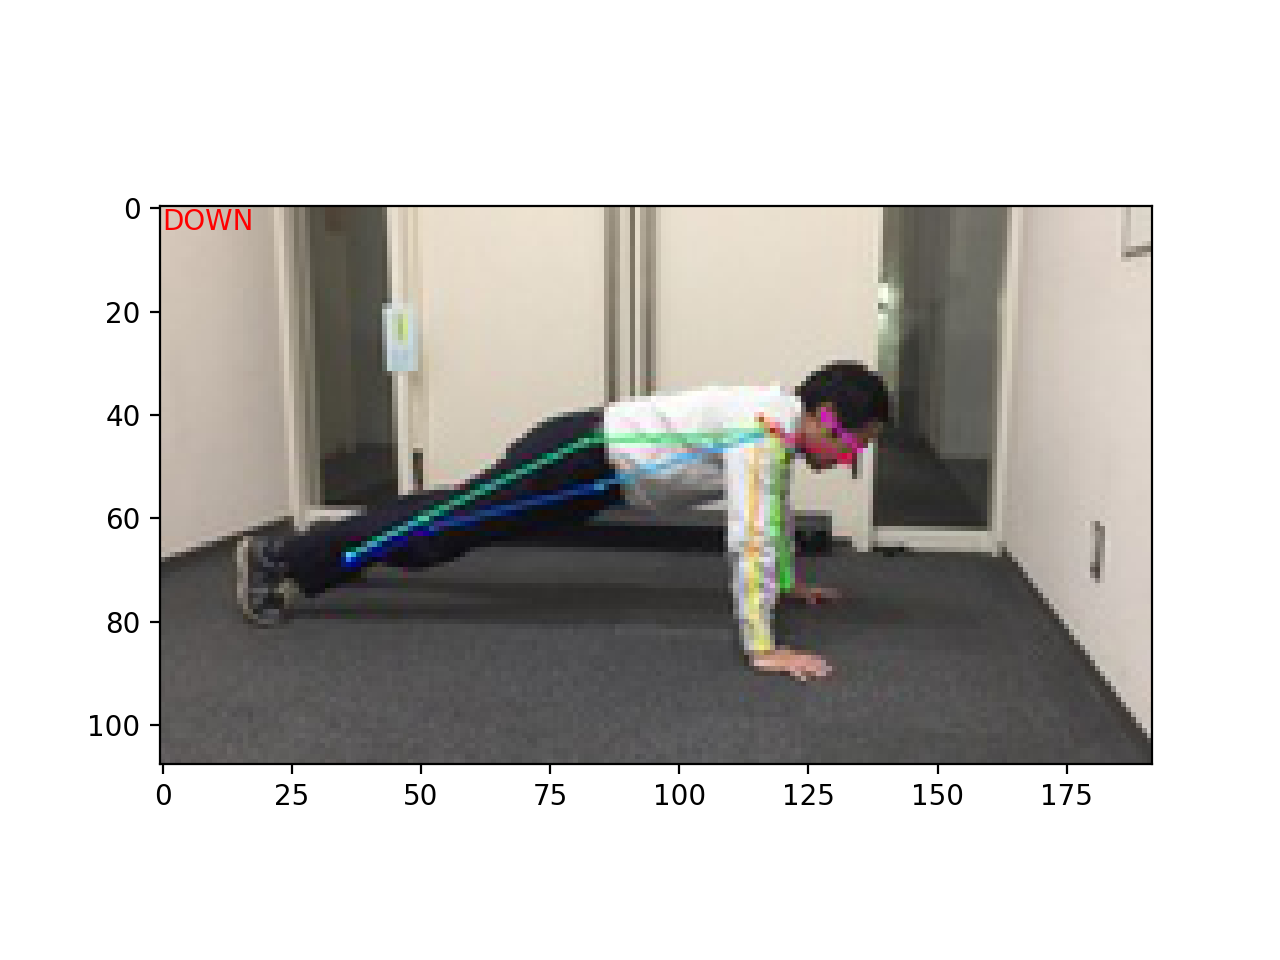

In [146]:
%matplotlib nbagg

fig = plt.figure()
imgs_pardir = "../data/movie_push-ups-from-side/2-3.COCO-pict-mini/"
imgs_folder = imgs_pardir + movi_base

img_files = sorted(glob.glob(imgs_folder + "/*.jpg"))
test_img_files = img_files

ims = []
for i, img_file in enumerate(test_img_files):
    img = plt.imread(img_file)
    text = "UP" if pred_label[i] == 1 else "DOWN"
    ims.append([plt.imshow(img), plt.text(0, 0, text, ha="left", va="top", color="red")])
    
ani = animation.ArtistAnimation(fig, ims, interval=10, repeat=True)
plt.show()

# SVM（低Confは無視）
結果：やっぱり、クラス間がきっぱり分かれずに連続的に変化してないから微妙な気がする

くっつけてラベルも作る

| クラス | ラベル |
|:------|------:|
|up|1|
|down|0|
|unknown|-1|

In [201]:
conf_thresh_train = .7
conf_thresh_test = .0

In [187]:
test_ratio = 0.5

train_data = np.vstack([nm_up_pos, nm_down_pos])
test_data = nm_movie_pos
print(train_data.shape)

(12, 6)


In [188]:
labels = np.hstack([
    1 * np.ones(nm_up_pos.shape[0], dtype=int),
    0 * np.ones(nm_down_pos.shape[0], dtype=int)
])
print(labels.shape)

(12,)


In [189]:
clf = SVC()
clf.fit(train_data, labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [202]:
pred_label = clf.predict(test_data)
print(pred_label)

[0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [203]:
pred_label[np.mean(movie_conf, axis=1) < conf_thresh_test] = -1
print(pred_label)

[0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

<IPython.core.display.Javascript object>


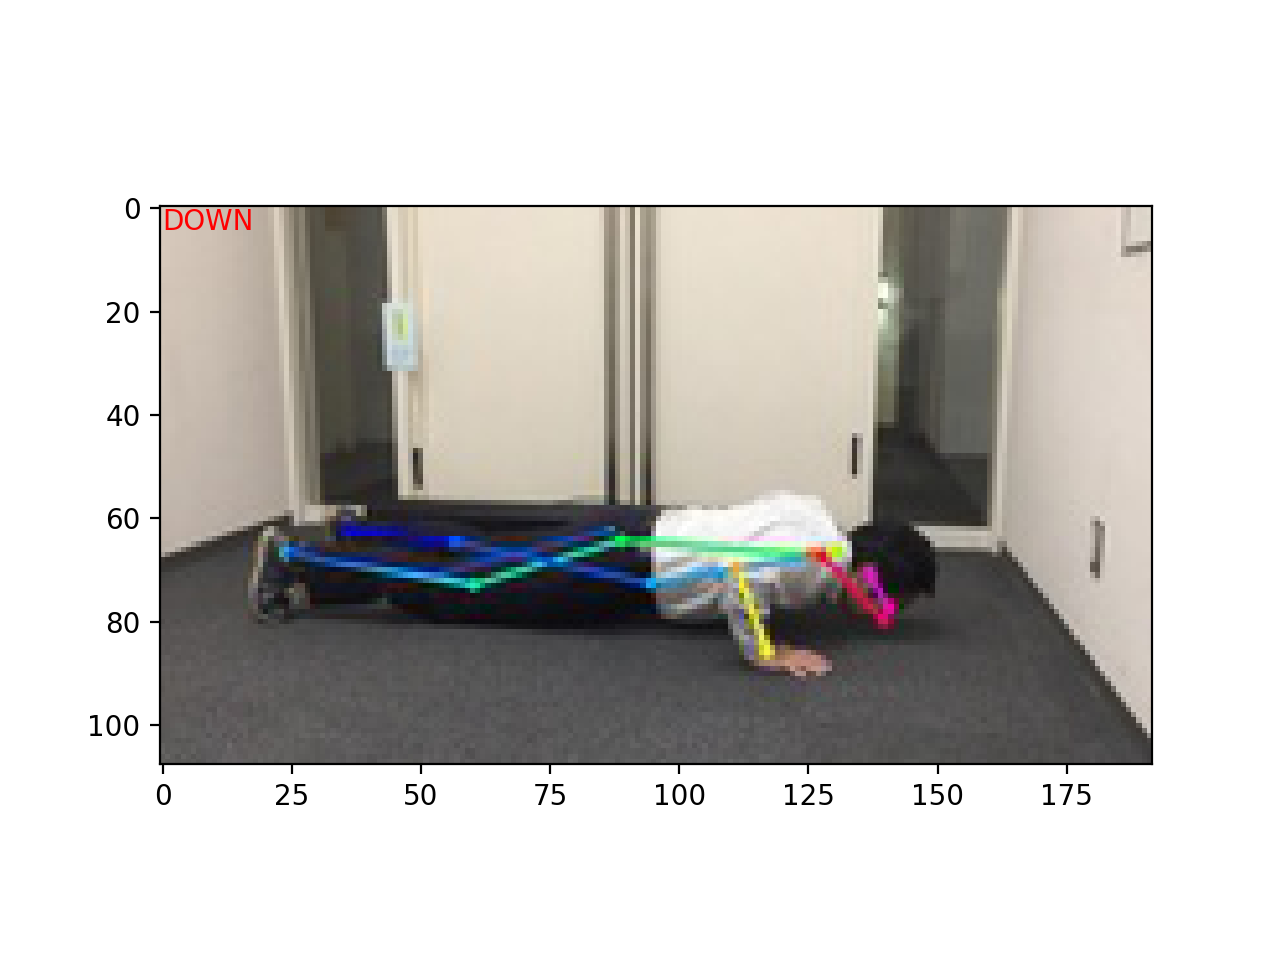

In [185]:
%matplotlib nbagg

fig = plt.figure()
imgs_pardir = "../data/movie_push-ups-from-side/2-3.COCO-pict-mini/"
imgs_folder = imgs_pardir + movi_base

img_files = sorted(glob.glob(imgs_folder + "/*.jpg"))
test_img_files = img_files[train_max_index:]

ims = []
for i, img_file in enumerate(test_img_files):
    img = plt.imread(img_file)
    if pred_label[i] == 1:
        text = "UP"
    elif pred_label[i] == 0:
        text = "DOWN"
    else:
        text = "UNKNOWN"
    ims.append([plt.imshow(img), plt.text(0, 0, text, ha="left", va="top", color="red")])
    
ani = animation.ArtistAnimation(fig, ims, interval=10, repeat=True)
plt.show()